In [41]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
%env XLA_FLAGS=--xla_gpu_deterministic_ops=true TF_DETERMINISTIC_OPS=1

env: XLA_FLAGS=--xla_gpu_deterministic_ops=true TF_DETERMINISTIC_OPS=1


In [43]:
import pandas as pd
pd.options.display.float_format = '{:.4f}'.format

In [44]:
# from stable_baselines3.sac import SAC
from sbx import SAC
import pickle
from rewardFunctions.rewardFunction3 import CustomRewardFunction

test_name = 'sac_2024-04-29-87'

with open("./saved/sac/" + test_name + "/" + test_name + ".pkl", "rb") as f:
    env = pickle.load(f)

model = SAC.load("./saved/sac/" + test_name + "/" + test_name + ".zip", env=env)

observations = env.reset()
actions_list = []
rewards_list = []

while not env.done:
    actions, _ = model.predict(observations, deterministic=True)
    observations, reward, _, _ = env.step(actions)
    actions_list.append(actions)
    rewards_list.append(reward)

kpis = env.evaluate()
kpis = kpis.pivot(index='cost_function', columns='name', values='value')
kpis = kpis.dropna(how='all')
display(kpis)

C:\Users\Domonkos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


name,Building_1,Building_2,District
cost_function,,,
annual_normalized_unserved_energy_total,0.0000,-0.0000,-0.0000
annual_peak_average,NaN,NaN,0.7558
carbon_emissions_total,0.9957,1.0981,1.0469
cost_total,0.9837,1.0869,1.0353
daily_one_minus_load_factor_average,NaN,NaN,0.7393
daily_peak_average,NaN,NaN,0.6678
discomfort_delta_average,-3.2760,-1.7385,-2.5072
discomfort_delta_maximum,0.8456,1.1519,0.9988
discomfort_delta_minimum,-6.6930,-5.5470,-6.1200


In [40]:
env.episode_rewards[-2:]

[{'min': [-21.752525329589844],
  'max': [-0.00011529965559020638],
  'sum': [-357.16607666015625],
  'mean': [-0.4967539310455322]},
 {'min': [-21.752527236938477],
  'max': [-0.00011527333117555827],
  'sum': [-357.1661376953125],
  'mean': [-0.4967540204524994]}]

In [45]:
import numpy as np

selected_env = env

avg_decrease = np.mean([(x - y) for x, y in zip(selected_env.net_electricity_consumption_without_storage, selected_env.net_electricity_consumption) if ((x > 6) and x > y)])
avg_increase = np.mean([(y - x) for x, y in zip(selected_env.net_electricity_consumption_without_storage, selected_env.net_electricity_consumption) if ((x > 6) and x < y)])

successful_peak_timesteps = [i for i, (x, y) in enumerate(zip(selected_env.net_electricity_consumption_without_storage, selected_env.net_electricity_consumption)) if (x > 6) and x > y]
unsuccessful_peak_timesteps = [i for i, (x, y) in enumerate(zip(selected_env.net_electricity_consumption_without_storage, selected_env.net_electricity_consumption)) if (x > 6) and x < y]

print(f"Number of successful peak timesteps: {len(successful_peak_timesteps)}")
print(f"Number of unsuccessful peak timesteps: {len(unsuccessful_peak_timesteps)}")
print(f"Successful peak timesteps: {successful_peak_timesteps}")
print(f"Unsuccessful peak timesteps: {unsuccessful_peak_timesteps}")
print(f"Average decrease: {avg_decrease}")
print(f"Average increase: {avg_increase}")

Number of successful peak timesteps: 14
Number of unsuccessful peak timesteps: 2
Successful peak timesteps: [7, 139, 154, 228, 253, 279, 343, 395, 438, 497, 536, 542, 563, 668]
Unsuccessful peak timesteps: [445, 537]
Average decrease: 2.4230099490710666
Average increase: 0.2410765290260315


6.561482
3.714917302131653
2.8465646505355835


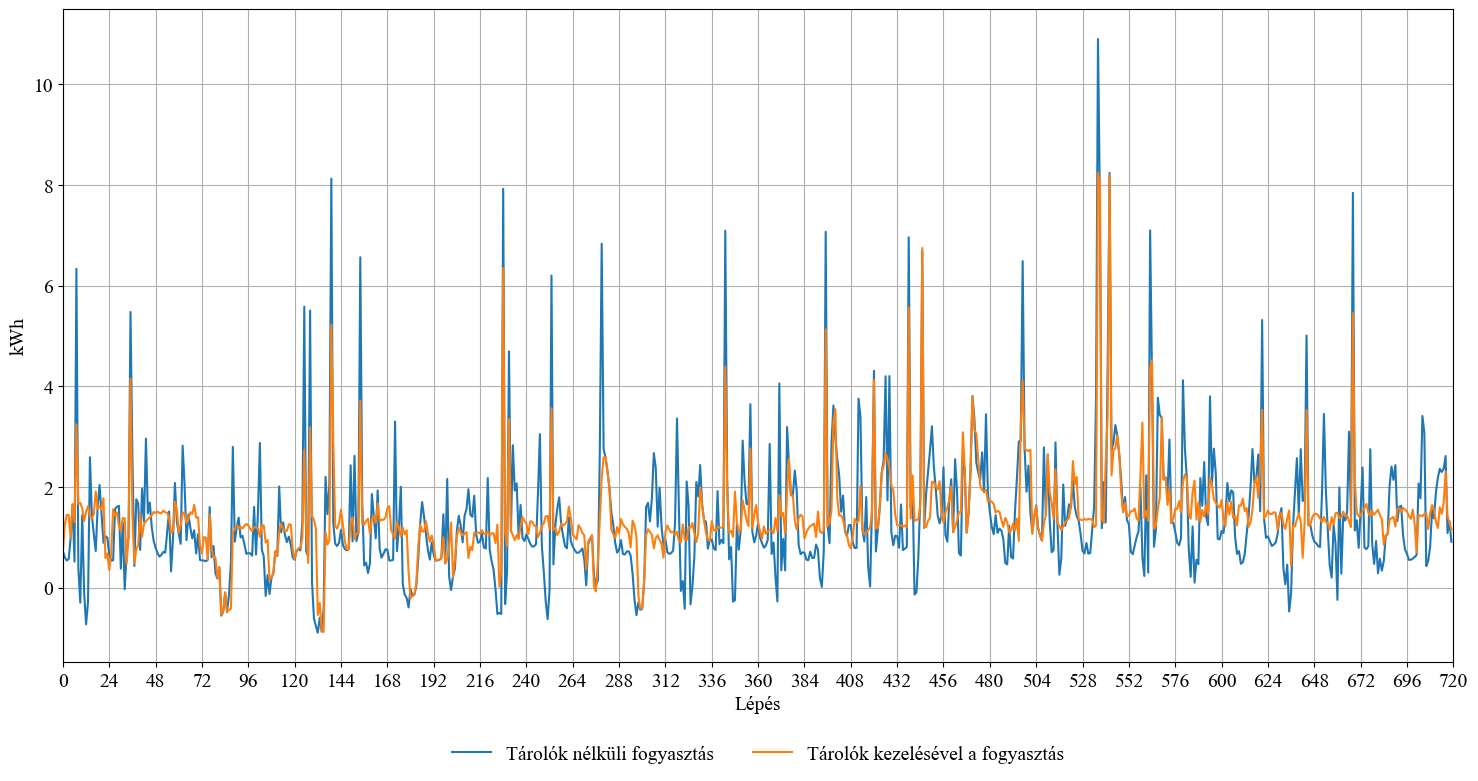

In [97]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams.update({'font.size': 14, 'font.family': 'Times New Roman'})

envs = {
    'SAC': env,
}

figsize = (15, 8)
fig, ax = plt.subplots(1, 1, figsize=figsize)

for k, v in envs.items():
    y = v.net_electricity_consumption_without_storage
    x = range(len(y))
    ax.plot(x, y, label="Tárolók nélküli fogyasztás")
    y = v.net_electricity_consumption
    x = range(len(y))
    ax.plot(x, y, label="Tárolók kezelésével a fogyasztás")

# y = v.electrical_storage_electricity_consumption
# ax.plot(x, y, label='Battery')
# y = v.dhw_storage_electricity_consumption
# ax.plot(x, y, label='DHW storage')

print(v.net_electricity_consumption_without_storage[154])
print(v.net_electricity_consumption[154])
print(v.net_electricity_consumption_without_storage[154] - v.net_electricity_consumption[154])

ax.set_xlabel('Lépés')
ax.set_ylabel('kWh')
# ax.set_xlim(144, 168)
# ax.set_ylim(-1, 7)
ax.set_xlim(0, 720)
ax.xaxis.set_major_locator(ticker.MultipleLocator(24))
ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), framealpha=0.0, fancybox=True, ncol=2)

plt.grid()
plt.tight_layout()

-45.28995651189063


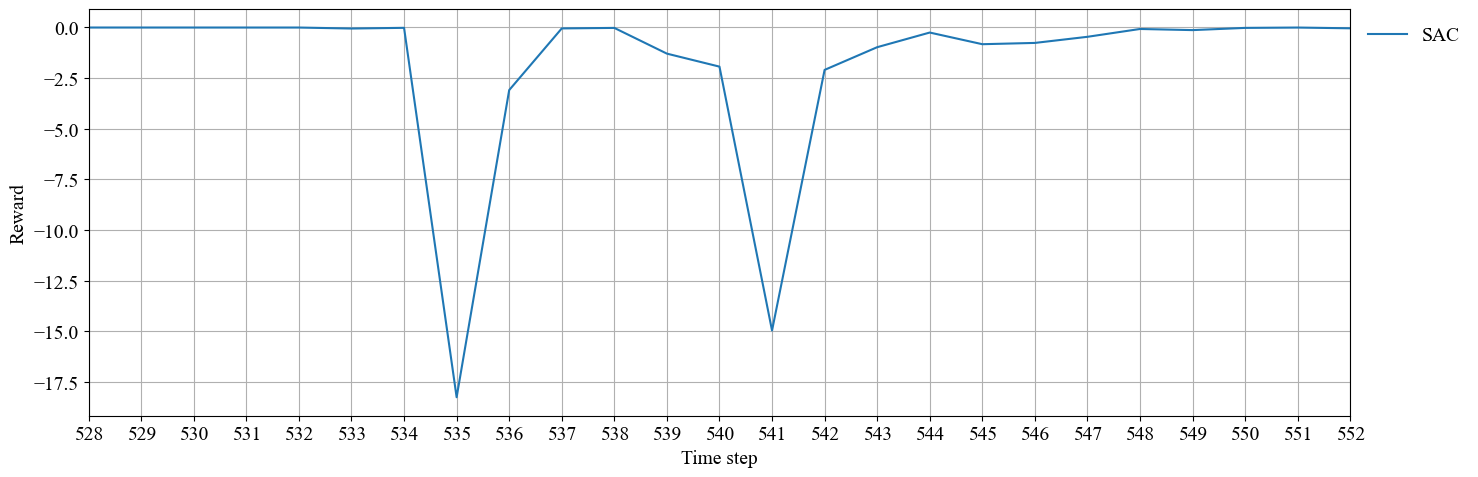

In [74]:
import matplotlib.ticker as ticker
%matplotlib inline

figsize = (15.0, 5)
fig, ax = plt.subplots(1, 1, figsize=figsize)

y = rewards_list
x = range(len(y))
ax.plot(x, y, label=k)

print(np.sum(rewards_list[528:552]))

ax.set_xlabel('Time step')
ax.set_ylabel('Reward')
# ax.set_ylim(-2, 3)
ax.set_xlim(528, 552)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0)
plt.grid()

plt.tight_layout()

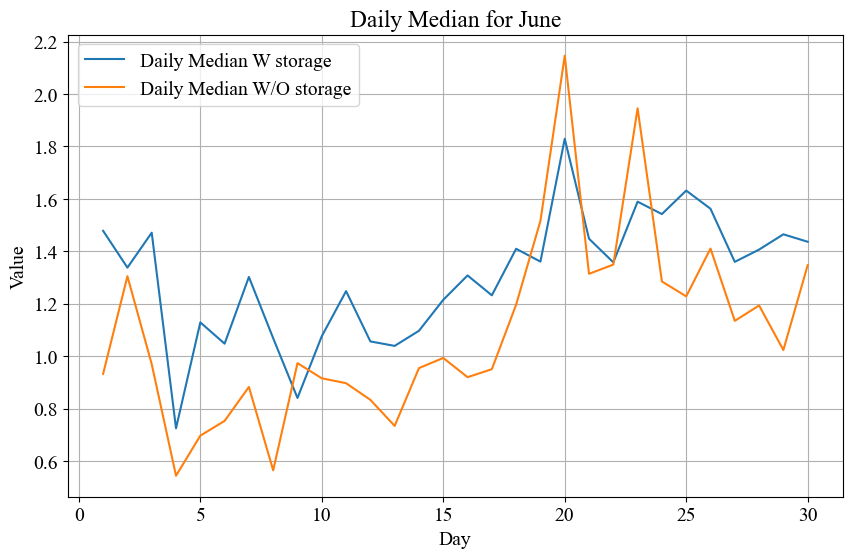

: 

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

hourly_data_with_storage = pd.DataFrame({'value': env.net_electricity_consumption})
daily_data_with_storage = [hourly_data_with_storage[i:i+24] for i in range(0, len(hourly_data_with_storage), 24)]

daily_averages_with_storage = [day.mean() for day in daily_data_with_storage]
daily_medians_with_storage = [day.median() for day in daily_data_with_storage]
daily_90th_percentiles_with_storage = [np.percentile(day, 50) for day in daily_data_with_storage]


hourly_data_without_storage = pd.DataFrame({'value': env.net_electricity_consumption_without_storage})
daily_data_without_storage = [hourly_data_without_storage[i:i+24] for i in range(0, len(hourly_data_without_storage), 24)]

daily_averages_without_storage = [day.mean() for day in daily_data_without_storage]
daily_medians_without_storage = [day.median() for day in daily_data_without_storage]
daily_90th_percentiles_without_storage = [np.percentile(day, 50) for day in daily_data_without_storage]

# Plotting
plt.figure(figsize=(10, 6))
# plt.plot(range(1, len(daily_averages_with_storage) + 1), daily_averages_with_storage, label='Daily Average W storage')
plt.plot(range(1, len(daily_medians_with_storage) + 1), daily_medians_with_storage, label='Daily Median W storage')
# plt.plot(range(1, len(daily_90th_percentiles_with_storage) + 1), daily_90th_percentiles_with_storage, label='Daily 90th percentile W storage')
# plt.plot(range(1, len(daily_averages_without_storage) + 1), daily_averages_without_storage, label='Daily Average W/O storage')
plt.plot(range(1, len(daily_medians_without_storage) + 1), daily_medians_without_storage, label='Daily Median W/O storage')
# plt.plot(range(1, len(daily_90th_percentiles_without_storage) + 1), daily_90th_percentiles_without_storage, label='Daily 90th percentile W/O storage')
plt.xlabel('Day')
plt.ylabel('Value')
plt.title('Daily Median for June')
plt.legend()
plt.grid(True)
plt.show()

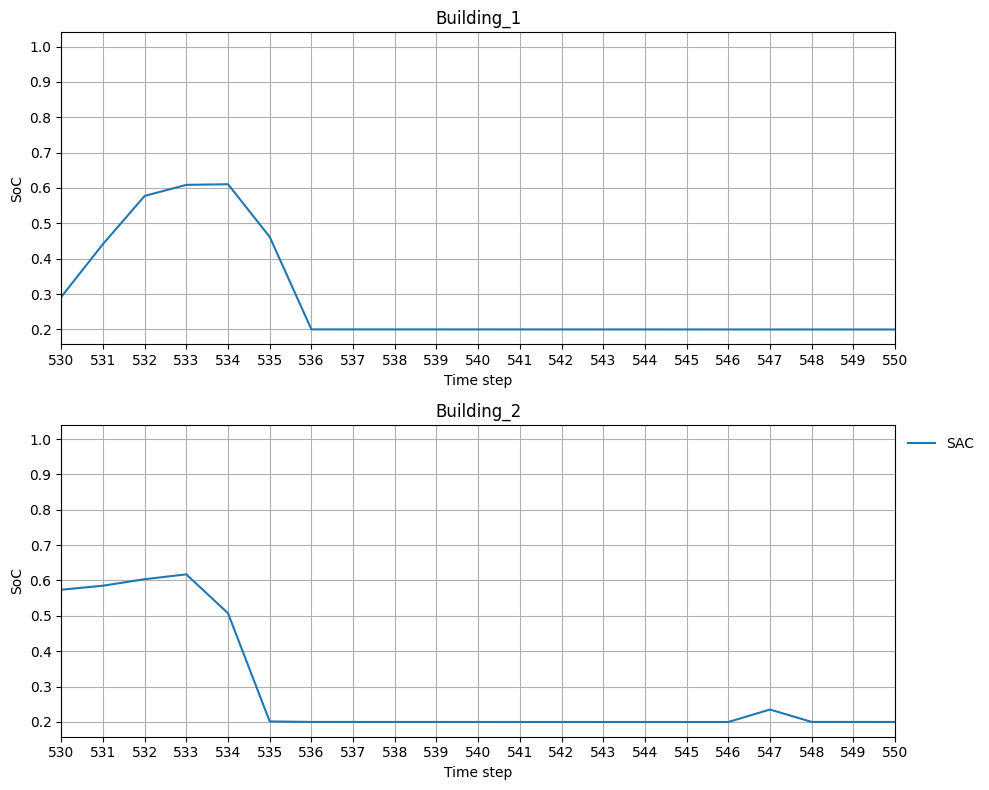

In [32]:
import math
%matplotlib inline

envs = {
    'SAC': env,
}

building_count = len(list(envs.values())[0].buildings)
column_count_limit = 1
row_count = math.ceil(building_count/column_count_limit)
column_count = min(column_count_limit, building_count)
figsize = (10.0*column_count, 4*row_count)
fig, _ = plt.subplots(row_count, column_count, figsize=figsize)

for i, ax in enumerate(fig.axes):
    for k, v in envs.items():
        soc = np.array(v.buildings[i].electrical_storage.soc)
        capacity = v.buildings[i].electrical_storage.capacity_history[0]
        y = soc
        x = range(len(y))
        ax.plot(x, y, label=k)

    ax.set_title(v.buildings[i].name)
    ax.set_xlabel('Time step')
    ax.set_ylabel('SoC')
    ax.set_xlim(530, 550)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.grid()

    if i == building_count - 1:
        ax.legend(
            loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0
        )
    else:
        ax.legend().set_visible(False)


plt.tight_layout()

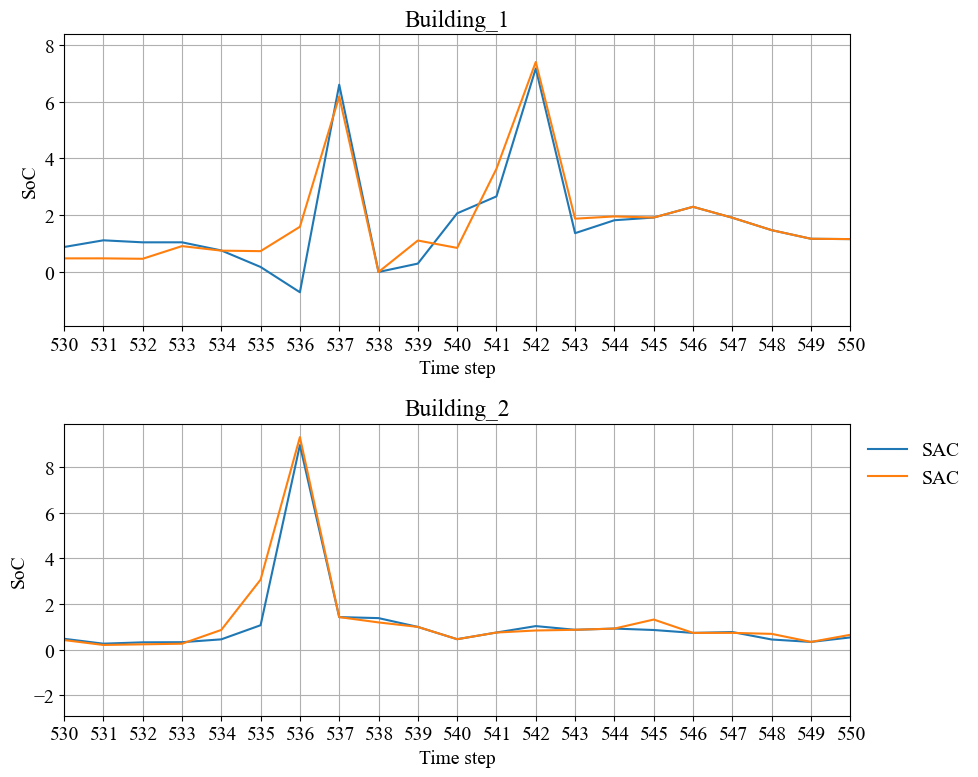

In [73]:
import math
%matplotlib inline

envs = {
    'SAC': env,
}

building_count = len(list(envs.values())[0].buildings)
column_count_limit = 1
row_count = math.ceil(building_count/column_count_limit)
column_count = min(column_count_limit, building_count)
figsize = (10.0*column_count, 4*row_count)
fig, _ = plt.subplots(row_count, column_count, figsize=figsize)

for i, ax in enumerate(fig.axes):
    for k, v in envs.items():
        soc = np.array(v.buildings[i].electrical_storage.soc)
        capacity = v.buildings[i].electrical_storage.capacity_history[0]
        y = v.buildings[i].net_electricity_consumption
        x = range(len(y))
        ax.plot(x, y, label=k)
        y = v.buildings[i].net_electricity_consumption_without_storage
        x = range(len(y))
        ax.plot(x, y, label=k)

    ax.set_title(v.buildings[i].name)
    ax.set_xlabel('Time step')
    ax.set_ylabel('SoC')
    ax.set_xlim(530, 550)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.grid()

    if i == building_count - 1:
        ax.legend(
            loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0
        )
    else:
        ax.legend().set_visible(False)


plt.tight_layout()